# Load library and define class and functions

In [28]:
import pickle
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import sys
sys.path.insert(0, "../")
from acousticFeatures import getAllFeatures
import parselmouth 
import numpy as np
from pydub import AudioSegment
from IPython.display import Audio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

def parse_metric(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return {'FP': FP, 'FN': FN, 'TP':TP, 'TN':TN, 'TPR': TPR, 'TNR': TNR, 'PPV' : PPV, 'NPV' :NPV, 'FPR': FPR, 'FNR': FNR,
           'FDR': FDR, 'ACC':ACC}


class Input:
    def __init__(self, code=None, excited=None, valance=None, arouse=None):
        self.__code = code
        self.__excited = excited
        self.__valance = valance
        self.__arouse = arouse
    
    def get_code(self):
        return self.__code
    
    def get_excited(self):
        return self.__excited
    
    def get_valance(self):
        return self.__valance
    
    def get_arouse(self):
        return self.__arouse
    
class Output:
    def __init__(self, dataFrame=None):
        self.__dataFrame = dataFrame
          
    def get_data_frame(self):
        return self.__dataFrame
        

# Load input, output

In [ ]:
input = pickle.load(open('processed-data/input-interview-framlength4-overlap2.obj', 'rb'))
output = pickle.load(open('processed-data/output-interview.obj', 'rb'))

# Analyze 

## 1. Agg excited values with percentage of excited frame

In [1]:
# Percentage of frame
excited = np.array([i.get_excited() for i in input])
percentage_excited_frame = np.array([np.sum(e) / len(e) for e in excited])

# Excited value of annotators
df = output.get_data_frame() 
excited_values = []
for k in df.Participant.unique():
    df1 = df.loc[df['Participant'] == k]
    v = df1.iloc[-1]
    excited_values.append(v['Excited'])

# DrAW scatter
plt.scatter(percentage_excited_frame, excited_values) 
plt.xlabel("Percentage of Excited Frame (%)")
plt.ylabel("Excited")

NameError: name 'np' is not defined

**ROC**

In [ ]:
split_point = np.median(excited_values)
y_binary = [ int(e >= split_point) for e in excited_values]

thresholds = np.linspace(0, 1.0, 50)
tpr_arr = []
fpr_arr = []
thresh_arr = [] 
for t in thresholds:
    predict_binary = np.array([int(i >= t) for i in x])
    cfm = confusion_matrix(y_binary, predict_binary)
    parse_values = parse_metric(cfm)
    tpr_arr.append(parse_values['TPR'])
    fpr_arr.append(parse_values['FPR'])
    thresh_arr.append(t)
    print("Threshold:{}, ACC:{}".format(t,parse_values['ACC'][0] ))

fpr_arr = np.asarray(fpr_arr)
tpr_arr = np.asarray(tpr_arr)
roc_auc = auc(fpr_arr[:,1], tpr_arr[:,1])
plt.plot(fpr_arr[:,1], tpr_arr[:,1], label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show();

Threshold:0.0, ACC:0.5
Threshold:0.02040816326530612, ACC:0.5
Threshold:0.04081632653061224, ACC:0.5
Threshold:0.061224489795918366, ACC:0.5
Threshold:0.08163265306122448, ACC:0.5072463768115942
Threshold:0.1020408163265306, ACC:0.5217391304347826
Threshold:0.12244897959183673, ACC:0.5217391304347826
Threshold:0.14285714285714285, ACC:0.5217391304347826
Threshold:0.16326530612244897, ACC:0.5217391304347826
Threshold:0.18367346938775508, ACC:0.5217391304347826
Threshold:0.2040816326530612, ACC:0.5289855072463768
Threshold:0.22448979591836732, ACC:0.5362318840579711
Threshold:0.24489795918367346, ACC:0.5507246376811594
Threshold:0.26530612244897955, ACC:0.5579710144927537
Threshold:0.2857142857142857, ACC:0.5579710144927537
Threshold:0.3061224489795918, ACC:0.5652173913043478
Threshold:0.32653061224489793, ACC:0.5869565217391305
Threshold:0.3469387755102041, ACC:0.6014492753623188
Threshold:0.36734693877551017, ACC:0.6086956521739131
Threshold:0.3877551020408163, ACC:0.6086956521739131
T

C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


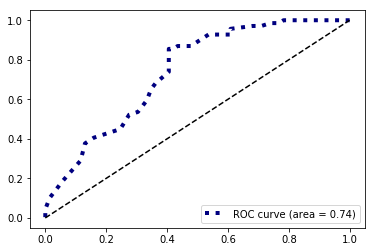